# Tutorial: Introduction to Brain Connectivity
### by Gorka Zamora-López, Ph.D.

XII Summer School in Statistics and Operation Research, July 2-6, 2018.   
Universitat Politècnica de Catalunya, Barcelona, Spain.

#### Dependencies
This tutorial requires a Python 3.X installation together with NumPy and Matplotlib libraries. To characterise the networks we will use the *[Graph Analysis Library](https://github.com/gorkazl/pyGAlib)* (**GAlib**), developed by Gorka Zamora-López. Find the library and installation instructions in the GitHub repository.   
**NOTE:** The official version of **GAlib** is released for Python 2.7. I will provide the newer version for Python 3.X to the students during the course. Find it in the BitBucket repository, in the "Code" folder.


### Import fundamental libraries

Let's get started. For that, the very first thing we need is to load the fundamental libraries we need to work. We will make an absolut import of *NumPy*.


In [1]:
from timeit import default_timer as timer
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import*

## Structural Connectivity –––––––––––––––––––––––––––––––––––––––––––––––
### Load the data and explore basic features of the network

In this exercise, we will reproduce the analysis done during the tutorial with the connectome of cats but using connectivity data from humans. In this case, the network consist of a parcellation of the human cortex into **68 Regions of Interest** (ROIs).

(20, 68, 68)
513111.79097892693


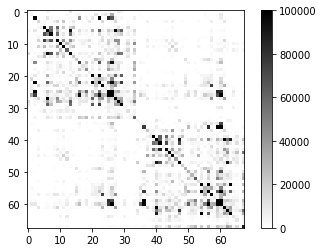

In [28]:
dataroot = 'datasets/resting/'
scnets = load(dataroot + 'Human/' + 'SCnets_20subs.npy')
print(shape(scnets))
netsym = scnets[0]
print(netsym.max())

plt.figure()
plt.imshow(netsym, cmap='gray_r')
plt.clim(0,100000)
plt.colorbar()

Most graph measures exist for directed networks, which provides richer information. Check for example the `Reciprocity()` and `ReciprocalDegree()` functions. GAlib functions usually come with an optional parameter `directed` in order to specify whether the undirected or the directed version of the measure is desired. By default, the parameter is set for exploration of undirected graphs: `directed=False`.

In case of human structural connectivity, the network is symmetric by construction, due to experimental limitations. So, no need to symmetrise the network then.

In [21]:
# Fundamental properties of the network
N = len(netsym)
L = 0.5 * netsym.astype(bool).sum()
Lmax = 0.5 * N*(N-1)
dens = L / Lmax

print('N: %d\t\tL: %d\t\tdensity: %1.3f' %(N, L, dens))

N: 68		L: 2308		density: 1.013


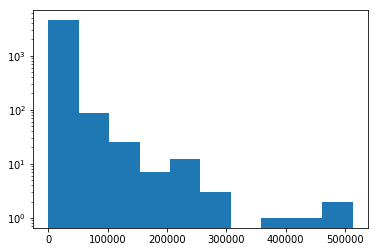

In [22]:
nzidx = netsym.nonzero()
scvalues = netsym[nzidx]

plt.figure()
plt.hist(scvalues, bins=10)
plt.xscale('linear')
plt.yscale('log')

0.12050043898156278


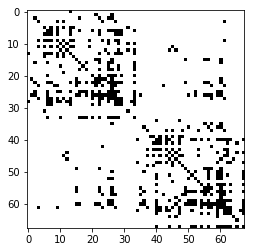

In [39]:
#Let's binarise the SC network...
binet = where(netsym>10000,1,0)
print(binet.sum() /(N*(N-1)))

plt.figure()
plt.imshow(binet,cmap='gray_r')

### Local network properties (Exercise – 1)
Let's start analysing the network. We will:
1. find its degree distribution, and
2. calculate the clustering coefficient

First of all, we need to import the functions from the Graph Analysis Library (GAlib). For now, we will use the module *galib.py*, which contains functions to estimate graph measures out of a graph.

Degrees: Min = 0, Max = 23, Mean degree: 8.074


Text(0.5,0,'Node degree')

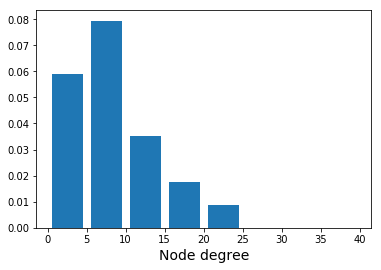

In [37]:
#import sys
#sys.path.insert(1, '../code/GAlib_Py3/')
from galib import Degree, Clustering, Density

deg = Degree(binet, directed=False)
print('Degrees: Min = %d, Max = %d, Mean degree: %1.3f' %(deg.min(), deg.max(), deg.mean()))

plt.figure()
plt.hist(deg, bins=8, range=(0,40), rwidth=0.8, density=True)
plt.xlabel('Node degree', fontsize=14)



In [35]:
C, Cnodes = Clustering(binet, checkdirected=False)

print( 'Clustering coefficient: %1.3f' %C )
print( 'Local clustering: Min = %1.3f, Max = %1.3f, Average = %1.3f' %(Cnodes.min(), Cnodes.max(), Cnodes.mean()) )

Clustering coefficient: 0.453
Local clustering: Min = 0.000, Max = 1.000, Average = 0.509


### Global network properties (Exercise – 2)

1. Compute the diameter of the network and its average pathlength
2. Calculate the betwenness centrality of the nodes

The Dijkstra is a famous algorithm to find the graph distance between a pair of nodes in a graph. However, if we want to calculate the distance between all pairs of graphs, the Floyd-Warshall algorithm is faster than running Dijkstra N^2 times. 

In [ ]:
from galib import FloydWarshall
Dij = FloydWarshall(netsym)

diam = Dij.max()
avpathlen = (Dij.sum() - Dij.trace()) / (N*(N-1))

print('Diameter: %d\tAv. Pathlen: %1.3f' %(diam, avpathlen))

In [ ]:
from galib import PathsAllinOne
Dij, bcnodes, paths, cycles = PathsAllinOne(netsym)
print( '\nBetweenness centrality. Min: %d\tMax: %d' %(bcnodes.min(), bcnodes.max()) )

In [ ]:
# Normalise BC of the nodes by all the existing shortest paths
# diameter was diam=3
npaths = len(paths[1]) + len(paths[2]) + len(paths[3])
bcnormed = bcnodes / npaths 

print( 'Total number of shortest paths: %d' %npaths )
print( 'Betweenness centrality. Min: %1.3f\tMax: %1.3f' %(bcnormed.min(), bcnormed.max()) )

In [ ]:
plt.figure()
plt.scatter(deg, bcnormed)
plt.xlabel('Node degree', fontsize=14)
plt.ylabel('Betweenness centrality', fontsize=14)
plt.xlim(0,45)
plt.grid(lw=0.5)

### Graph models. Null-models and benchmarks (Exercise – 3)

We will now compare the cat connectome with typical reference networks: *random graphs* and *degree-preserving random graphs*. These comparisons are **not** to be regarded as actual **significance tests**; but they serve to understand where some of the properties of the real connectome may arise from.

**Random graphs** are the fundamental (1st order) reference network model because the outcome of ALL graph measures strongly depends on how sparse, or how dense is the network. Thus, the properties of random graphs of same size *N* and number of links *L* as the real network indicate how far do the properties of the real network depend on their density.

Beyond *N* and *L*, we often want to know how much of the observed properties of a network may depend also on a third constraint, namely, the degree-distribution. Specially because the presence of hubs may alter the properties of the network. For that, we need to generate reference graphs with the same *N*, *L* and **k-sequence** as the original connectome, which are maximally random under those constraints.

In the GAlib library, the functions to generate different network models are located in the *gamodels.py* module.

In [ ]:
# Generate ensemble of random graphs with same N and L as the cat connectome
from gamodels import RandomGraph
nrealiz = 10
randnets = zeros((nrealiz,N,N), uint8)
for re in range(nrealiz):
    randnets[re] = RandomGraph(N,L, directed=False)

In [ ]:
# Generate ensemble of random graphs with same N and L and k-sequence as the cat connectome
from gamodels import RewireNetwork
rewnets = zeros((nrealiz,N,N), uint8)
for re in range(nrealiz):
    rewnets[re] = RewireNetwork(netsym, prewire=10, directed=False, weighted=False)

#### Compare the degree distributions

In [ ]:
deglist_rand = []
deglist_rew = []
for re in range(nrealiz):
    deglist_rand += Degree(randnets[re], directed=False).tolist()
    deglist_rew += Degree(rewnets[re], directed=False).tolist()
deglist_rand = array(deglist_rand, dtype=uint)
deglist_rew = array(deglist_rew, dtype=uint)

print('\nDEGREES')
print('Cat \t Min = %d, Max = %d,\t Mean degree: %1.3f' %(deg.min(), deg.max(), deg.mean()))
print('Random \t Min = %d, Max = %d,\t Mean degree: %1.3f' %(deglist_rand.min(), deglist_rand.max(), deglist_rand.mean()) )
print('Rew \t Min = %d, Max = %d,\t Mean degree: %1.3f' %(deglist_rew.min(), deglist_rew.max(), deglist_rew.mean()))

In [ ]:
# Plot the degree distributions
plt.figure()
plt.hist(deglist_rand, bins=8, range=(0,40), rwidth=0.8, density=True)
plt.xlabel('Node degree', fontsize=14)

plt.figure()
plt.hist(deglist_rew, bins=8, range=(0,40), rwidth=0.8, density=True)
plt.xlabel('Node degree', fontsize=14)

#### Compare the clustering coefficient

In [ ]:
Clist_rand = zeros(nrealiz, float)
Clist_rew = zeros(nrealiz, float)
for re in range(nrealiz):
    Crand, Cnodes_rand = Clustering(randnets[re])
    Clist_rand[re] = Crand
    Crew, Cnodes_rew = Clustering(rewnets[re])
    Clist_rew[re] = Crew

print('\nCLUSTERING COEFFICIENT')
print('Cat:\t%1.3f \nRandom:\t%1.3f \nRew:\t%1.3f' %(C, Crand, Crew))

#### Compare the pathlength and betweenness centrality

In [ ]:
# First, calculate pathlengths and BC from the RANDOM graphs
avlenlist_rand = zeros(nrealiz, float)
bclist_rand = []
triuidx = triu_indices(N, k=1)
for re in range(nrealiz):
    Dij_rand, BC_rand, paths, cycles = PathsAllinOne(randnets[re])
    values = Dij_rand[triuidx]
    avlenlist_rand[re] = values.mean()
    bclist_rand += BC_rand.tolist()

# Calculate pathlengths and BC from the REWIRED graphs
avlenlist_rew = zeros(nrealiz, float)
bclist_rew = []
for re in range(nrealiz):
    Dij_rew, BC_rew, paths, cycles = PathsAllinOne(rewnets[re])
    values = Dij_rew[triuidx]
    avlenlist_rew[re] = values.mean()
    bclist_rew += BC_rew.tolist()


In [ ]:
# Results for the average pathlength 
plt.figure()
plt.title('Comparison of average pathlengths', fontsize=14)
plt.bar( (1,2,3), (avpathlen, avlenlist_rand.mean(), avlenlist_rew.mean()) )
plt.ylim(1,2)
plt.xticks((1,2,3), ('Cat', 'Random', 'Rewired') )
plt.grid(axis='y', lw=0.5)


In [ ]:
# Results for the betweenness centrality
plt.figure()
plt.scatter(deg*deg, bcnodes)
plt.plot(deglist_rand**2, bclist_rand, '.', color='red', zorder=10)
plt.plot(deglist_rew**2, bclist_rew, '.', color='orange', zorder=5)
plt.xlabel('Node degree', fontsize=14)
plt.ylabel('Betweenness centrality', fontsize=14)
#plt.xlim(0,45)
plt.grid(lw=0.5)

# Try again with k**2. (comment'xlim' out). What happens?

## Functional Connectivity –––––––––––––––––––––––––––––––––––––––––––––––

Usually, functional connectivity is obtain from dynamic / statistic measures to estimate the "closeness" between the temporal activity of two brain regions. Here, we don't have fMRI or EEG data from the brain of cats so, just for illustration purposes, we will compute an estimate (a prediction) of the FC. This estimate, *Topological similarity*, represents a diffusion process in the network. See Bettinardi, Deco et al. (2017) "*[How structure sculpts function: Unveiling the contribution of anatomical connectivity to the brain's spontaneous correlation structure](http://aip.scitation.org/doi/10.1063/1.4980099)*" Chaos, 27, 047409.

In [ ]:
import scipy.linalg
def TopologicalSimilarity(adjmatrix, coupling):
    """Computes the expected cross-correlation matrix of a given network.

    This function estimates the expected correlations between its nodes that
    a dynamical process on the network tends to generate. The estimation assumes
    that the "influence" of one node over another distributes over all possible
    paths but that the influence decays along the paths. This decay is estimated
    as the communicability matrix. Pairwise correlation is assumed, according
    to the patterns of inputs two nodes tend to receive.
    See further details in our paper:
    "Bettinardi et al. Chaos 27:047409 (2017)"

    Parameters
    ----------
    adjmatrix : ndarray of rank-2
        The adjacency matrix of the network.
    coupling : real valued number
        The coupling strength of all connections.

    Returns
    -------
    corrmatrix : ndarray of rank-2, same size as adjmatrix.
        The correlation matrix of the expected functional connectivity.

    See Also
    --------
    ExponentialMapping : Expected cross-correlation matrix of a given network.
    CovarianceLinearGaussian : Covariance matrix of an Ornstein-Uhlenbeck process.
    """
    # 0) Security check on the dtype
    if adjmatrix.dtype not in ['float32','float64','float']:
        adjmatrix = adjmatrix.astype(float64)

    # 1) Compute the communicability matrix
    Cmatrix = scipy.linalg.expm(coupling*adjmatrix).T

    # 2) Compute the product between all columns (Cmatrix was transposed)
    #    and the normalization
    corrmatrix = inner(Cmatrix, Cmatrix)
    norms = scipy.linalg.norm(Cmatrix, axis=1)
    normmatrix = outer(norms, norms.T)

    corrmatrix = corrmatrix / normmatrix
    return corrmatrix


In [ ]:
# Coupling strength
g = 0.09 #0.0766
fcnet = TopologicalSimilarity(netsym, g)

plt.figure()
plt.imshow(fcnet, cmap='jet')
plt.clim(0,1)
plt.colorbar()

In [ ]:
from galib import Intensity
intens = Intensity(fcnet, directed=False)

# Compare SC degree and FC intensity
plt.figure()
plt.scatter(deg, intens)
plt.xlabel('Node degree (SC)', fontsize=14)
plt.ylabel('Node intensity (FC)', fontsize=14)
plt.grid(lw=0.5)

In [ ]:
# Compare the graph distance and the pair-wise correlations
distvalues = Dij[triuidx]
fcvalues = fcnet[triuidx]
plt.figure()
plt.plot(distvalues, fcvalues, '.')
plt.xlabel('Graph distance (SC)', fontsize=14)
plt.ylabel('Correlation (FC)', fontsize=14)